# Feature engineering and selection

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_auc_score

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def load_data_set():
    train_data = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    test["outcome"] = 9
    bids = pd.read_csv('bids.csv')
    bids = bids.sort(['auction', 'time'])
    return train_data,bids,test

train,bids,test = load_data_set()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [3]:
'''
Alors fonction generer pour les bids l'ensemble des donnees suivantes : 
Pour chaque vente : temps moyen,max, std et min entre deux bids d une meme personne
                    temps moyen,max, st entre deux bids
                    nombre de bids max, min, et moyen de chaque utilisateur 
sauvegarde des resultats dans 3 csv differents
'''
def time_into_auction(train,bids,test):
    human = train[train.outcome==0].bidder_id
    bot = train[train.outcome==1].bidder_id
    grouped = bids.groupby('auction')
    done = -5
    #temps de bid par rapport aux dans une meme vente
    times_df = {}
    #temps de bid par rapport a soit meme pour chaque vente
    bid_himselft = {}
    #number of bids:
    number_bids = {}
    #wins auctions
    wins_auctions = {}
    moments_bids_final = {}
    remaining = len(grouped)
    for bides in grouped:
        sub_data= bides[1]
        sub_data.sort("time")
        difference=  [0,0]
        last_bids = {}
        current_bids = {}
        start = 0
        end  = 0
        has_win = -1
        moments_bids = {}
        for acc in sub_data.iterrows():
            i,line = acc
            cle = line['bidder_id']
            if difference[0] == 0:
                difference[0] = line['time']
                start = line['time']
            else:
                if not cle in times_df:
                    times_df[cle] = []
                times_df[cle].append(line['time']-difference[0])
                difference[0] = line['time']
            if cle not in moments_bids:
                moments_bids[cle]= [line['time']]
            else:
                moments_bids[cle].append(line['time'])
            if cle not in last_bids:
                last_bids[cle] = (line['time'],[])
            else:
                last_bids[cle][1].append(line['time']-last_bids[cle][0])
                last_bids[cle] = (line['time'],last_bids[cle][1])
            if cle not in current_bids:
                current_bids[cle] = 1
            else:
                current_bids[cle] +=1
            end = line['time']
            has_win = cle
        #fusion des dictionnaires
        for c in current_bids:
            if not c in number_bids:
                number_bids[c] = [current_bids[c]]
            else:
                number_bids[c].append(current_bids[c])
        for c in last_bids:
            if not c in bid_himselft and len(last_bids[c][1])>0:
                bid_himselft[c] = last_bids[c]
            elif  len(last_bids[c][1])>0:
                bid_himselft[c] += last_bids[c]
        for c in moments_bids:
            if c not in moments_bids_final:
                moments_bids_final[c] = []
            moments_bids_final[c] += [((od-start)/float((end-start)+1.0)) for od in moments_bids[c]]
        loose = sub_data["bidder_id"].unique()
        for c in loose:
            if c not in wins_auctions:
                wins_auctions[c] = [0,0]
            wins_auctions[c][has_win==c] +=1
        if remaining %200 ==0:
            print("remaining : ", remaining)
        remaining -=1
    df = []
    for c in wins_auctions:
        wins_auctions[c] = wins_auctions[c][1] / float(np.sum(wins_auctions[c]))
    for cle in times_df.keys():
        df.append({'bidder_id': cle, 'mean_autres': np.mean(times_df[cle]),
    'min_autres': np.min(times_df[cle]), 'max_autres': np.max(times_df[cle]),'std_autres': np.std(times_df[cle])})
    pd.DataFrame(df).to_csv('res/time_auction.csv', index=False)
    df = []
    for cle in number_bids.keys():
        df.append({'bidder_id': cle, 'mean_number_bids': np.mean(number_bids[cle]),
    'min_number_bids': np.min(number_bids[cle]), 'max_number_bids': np.max(number_bids[cle]),
    'number_bids': len(number_bids[cle]),'std_number_bids': np.std(number_bids[cle])})
    pd.DataFrame(df).to_csv('res/bids_number.csv', index=False)
    df  = []
    for cle in bid_himselft.keys():
        val = bid_himselft[cle][1]
        df.append({'bidder_id': cle, 'mean_time_bids': np.mean(val),
    'min_time bids': np.min(val), 'max_time_bids': np.max(val),
    'number_of_auctions_bids': len(val),'std_time_bids': np.std(val)})
    pd.DataFrame(df).to_csv('res/himslef_time.csv', index=False)
    df  = []
    for cle in moments_bids_final.keys():
        #10 percent starting :
        #10 percent ending :
        starting = [(fre<0.1) for fre in moments_bids_final[cle]]
        ending = [(fre>0.9) for fre in moments_bids_final[cle]]
        #print(moments_bids_final[cle][moments_bids_final[cle]>0.10])
        df.append({'bidder_id': cle, 'average_moment_bid': np.mean(moments_bids_final[cle]),
    'std_moment_bid':np.std(moments_bids_final[cle]),'frequence_wind':wins_auctions[cle], 'starting_quick' : float(np.sum(starting))/float(len(starting)),
        'ending_quick' : float(np.sum(ending))/float(len(ending))})
    pd.DataFrame(df).to_csv('res/other_stats.csv', index=False)
    

recreate_feature = False
if recreate_feature:
    time_into_auction(train,bids,test)

'''How to detect a bot ?
Same ip
Fast biding
Bid faster than human
#
average time between two bids
time since bid starting
number of bids
max time

faire par rapport aux autres utilisateurs et faire par rapport a lui meme
average number of bids per auction
max number of bids per auction
'''

'How to detect a bot ?\nSame ip\nFast biding\nBid faster than human\n#\naverage time between two bids\ntime since bid starting\nnumber of bids\nmax time\n\nfaire par rapport aux autres utilisateurs et faire par rapport a lui meme\naverage number of bids per auction\nmax number of bids per auction\n'

In [4]:
import pickle
import os.path

def normalize(dicts):
    for c in dicts:
        tmp = dicts[c]
        total = float(np.sum(tmp))
        dicts[c] = (tmp[0]/total,tmp[1]/total)
    return dicts
# generate the features using the features created before
def feature_creation(train,test,bids):
    #number of differents ips,urls
    grouped = bids.groupby(['bidder_id','auction'])
    app_mean = grouped.device.nunique().groupby(level=0).mean()
    app_std = grouped.device.nunique().groupby(level=0).count()
    app_max = grouped.device.nunique().groupby(level=0).max()
    ip_mean = grouped.ip.nunique().groupby(level=0).mean()
    ip_std = grouped.ip.nunique().groupby(level=0).count()
    ip_max = grouped.ip.nunique().groupby(level=0).max()
    pays_mean = grouped.country.nunique().groupby(level=0).mean()
    pays_std = grouped.country.nunique().groupby(level=0).count()
    pays_max = grouped.country.nunique().groupby(level=0).max()
    page_mean = grouped.url.nunique().groupby(level=0).mean()
    page_std = grouped.url.nunique().groupby(level=0).count()
    page_max = grouped.url.nunique().groupby(level=0).max()
    df = []
    for cle in app_mean.keys():
        df.append({'bidder_id' : cle, 'app_mean': app_mean[cle], 'app_std': app_std[cle],
    'app_max': app_max[cle], 'ip_mean': ip_mean[cle],
    'ip_std': ip_std[cle],'ip_max': ip_max[cle],'pays_mean': pays_mean[cle],'pays_std': pays_std[cle],'pays_max': pays_max[cle],
    'page_mean': page_mean[cle],'page_std': page_std[cle],'page_max': page_max[cle]})
    pd.DataFrame(df).to_csv('res/nb_uniques.csv', index=False)
    df = []
    return
    #hour in the day for the humans and for each country 
    human = train[train.outcome==0]
    bots = train[train.outcome==1]
    human_bids = bids[bids["bidder_id"].isin(human["bidder_id"])]
    robot_bids = bids[bids["bidder_id"].isin(bots["bidder_id"])]
    show_stats = False
    if show_stats:
        import matplotlib.pyplot as plt
        import seaborn as sn
        %matplotlib inline
        countries = bids["country"].unique()
        for c in countries:
            sub_d_h= human_bids[human_bids["country"] == c]
            sub_d_r= robot_bids[robot_bids["country"] == c]
            if len(sub_d_r)>1:
                tmp_plot = sub_d_h.groupby("time").count()
                tmp_plot2 = sub_d_r.groupby("time").count()
                plt.plot(tmp_plot.index,tmp_plot,label="human",alpha=0.7)
                plt.plot(tmp_plot2.index,tmp_plot2,label="robot",alpha=0.7)
                plt.legend()
                plt.show()
    #average moment of biding in the auction and win percentage
    countries = {}
    urls = {}
    devices = {}
    ips = {}
    auctions = {}
    merchandises = {}
    times = {}
    if os.path.exists("stats/urls.pkl"):
        with open('stats/urls.pkl', 'rb') as handle:
            urls = pickle.load(handle)
        with open('stats/countries.pkl', 'rb') as handle:
            countries = pickle.load(handle)
        with open('stats/devices.pkl', 'rb') as handle:
            devices = pickle.load(handle)
        with open('stats/merchandises.pkl', 'rb') as handle:
            merchandises = pickle.load(handle)
        with open('stats/auctions.pkl', 'rb') as handle:
            auctions = pickle.load(handle)
        with open('stats/times.pkl', 'rb') as handle:
            times = pickle.load(handle)
        print(len(auctions),len(times),len(merchandises),len(devices),len(countries),len(urls))
    else:
        to_do = len(bids)
        bots_values = bots["bidder_id"].values
        #basics stats
        for i,acc in bids.iterrows():
            url = acc["url"]
            country = acc["country"]
            device = acc["device"]
            bid = acc["auction"]
            merchan = acc["merchandise"]
            time = acc["time"]
            cle = acc["bidder_id"]
            bot = cle in bots_values
            if url not in urls:
                urls[url] = [0,0]
            if country not in countries:
                countries[country] = [0,0]
            if device not in devices:
                devices[device] = [0,0]
            if bid not in auctions:
                auctions[bid] = [0,0]
            if merchan not in merchandises:
                merchandises[merchan] = [0,0]
            if time not in times:
                times[time] = [0,0]
            if bot:
                urls[url][0] +=1
                countries[country][0] +=1
                devices[device][0] +=1
                merchandises[merchan][0] +=1
                auctions[bid][0] +=1
                times[time][0] +=1
            else:
                urls[url][1] +=1
                countries[country][1] +=1
                devices[device][1] +=1
                merchandises[merchan][1] +=1
                auctions[bid][1] +=1
                times[time][1] +=1 
            to_do -= 1
            if to_do % 100000 ==0:
                print(to_do)
        urls = normalize(urls)
        countries = normalize(countries)
        devices = normalize(devices)
        merchandises = normalize(merchandises)
        auctions = normalize(auctions)
        times = normalize(times)
        with open('stats/urls.pkl', 'wb') as handle:
            pickle.dump(urls, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/countries.pkl', 'wb') as handle:
            pickle.dump(countries, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/devices.pkl', 'wb') as handle:
            pickle.dump(devices, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/merchandises.pkl', 'wb') as handle:
            pickle.dump(merchandises, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/auctions.pkl', 'wb') as handle:
            pickle.dump(auctions, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('stats/times.pkl', 'wb') as handle:
            pickle.dump(times, handle, protocol=pickle.HIGHEST_PROTOCOL)
    grouped_person = bids.groupby(['bidder_id'])
    url_score = {}
    country_score = {}
    merchan_score = {}
    devices_score = {}
    auct_score = {}
    times_score = {}
    remaining = len(grouped_person)
    print("TO DO : ",remaining)
    bots_values = bots["bidder_id"].values
    for bides in grouped_person:
        sub_data= bides[1]
        for i,acc in sub_data.iterrows():
            cle = acc["bidder_id"]
            bot = cle in bots_values
            if cle not in url_score:
                url_score[cle] = urls[acc["url"]][int(bot)]
            if cle not in country_score:
                cle_c = acc["country"]
                if acc["country"] != "nan":
                    cle_c = "in"
                country_score[cle] = countries[cle_c][int(bot)]
            if cle not in merchan_score:
                merchan_score[cle] = merchandises[acc["merchandise"]][int(bot)]
            if cle not in devices_score:
                devices_score[cle] = devices[acc["device"]][int(bot)]
            if cle not in auct_score:
                auct_score[cle] = auctions[acc["auction"]][int(bot)]
            if cle not in times_score:
                times_score[cle] = times[acc["time"]][int(bot)]
        url_score[cle] = url_score[cle]  /float(len(sub_data))
        country_score[cle] = country_score[cle]  /float(len(sub_data))
        devices_score[cle] = devices_score[cle]  /float(len(sub_data))
        merchan_score[cle] = merchan_score[cle]  /float(len(sub_data))
        auct_score[cle] = auct_score[cle]  /float(len(sub_data))
        times_score[cle] = times_score[cle]  /float(len(sub_data))
        if remaining % 500 ==0:
            print(remaining)
        remaining -=1
    df  = []
    for cle in url_score.keys():
        df.append({'bidder_id' : cle, 'url_score': url_score[cle], 'country_score': country_score[cle],
    'device_score': devices_score[cle], 'merchan_score': merchan_score[cle],
    'zauc_score': auct_score[cle],'time_score': times_score[cle]})
    pd.DataFrame(df).to_csv('res/scores.csv', index=False)
    
    #to do : total number of bids, max nombre de bids dans une fentre de 15 minutes
    #nombre de bids pour chacun des jours
    '''
    heure moyen de bid
    number of simulatneous bids
    est ce que c'est une heire normale (calculer pour chaque pays fenetre la plus utilisee dans la journee)
    appartenir a url ? 'vasstdc27m7nks3(proba)
    '''
recreate = False
if recreate:
    feature_creation(train,test,bids)

In [5]:
# Generate new features :
from collections import Counter
def new_features(train,test,bids):
    countries= bids.country.unique()
    countries_nb = {}
    for c in countries:
        countries_nb[c] = bids[bids["country"] == c].bidder_id.value_counts()
    #consecutive bids
    tmp = bids.groupby(["bidder_id"]).time
    max_four = {}
    max_five= {}
    max_six = {}
    remaining = len(tmp)
    consevuctive_bids_mean = {}
    consevuctive_bids_min = {}
    consevuctive_bids_std = {}
    for d in tmp:
        cle = d[0]
        sub_data= d[1]
        sub_data.sort()
        four = np.max(Counter([str(nb)[:4] for nb in sub_data]).values())
        five = np.max(Counter([str(nb)[:5] for nb in sub_data]).values())
        six = np.max(Counter([str(nb)[:6] for nb in sub_data]).values())
        diff = np.ediff1d(sub_data)
        if len(diff)>0:
            consevuctive_bids_mean[cle] = np.mean(diff)
            consevuctive_bids_min[cle] = np.min(diff)
            consevuctive_bids_std[cle]= np.std(diff)
        max_four[cle] = four
        max_five[cle] = five
        max_six[cle] = six
        if remaining % 1000 ==0:
            print(remaining)
        remaining -=1
    ips_india_user = bids[(bids["country"] == "in")].groupby(["bidder_id"]).ip.nunique()
    ips_per_user = (bids.groupby(["bidder_id"]).ip.nunique())
    unique_time_user = (bids.groupby(["bidder_id"]).time.nunique())
    device_per_user = (bids.groupby(["bidder_id"]).device.nunique())
    url_per_user = (bids.groupby(["bidder_id"]).url.nunique())
    total_auction = bids.groupby("bidder_id").auction.count()
    total_bids = bids["bidder_id"].value_counts()
    #bid in each country
    merchandises = bids.merchandise.unique()
    merchan_nb = {}
    for m in merchandises:
        merchan_nb[m] = bids[bids["merchandise"] == m].bidder_id.value_counts()
    df = []
    for c in total_bids.keys():
        tmp = {'bidder_id' : c,  "ips_per_user" : ips_per_user[c], "device_user" : device_per_user[c],
                  "unq_time_user" : unique_time_user[c], "url_user" : url_per_user[c]}
        if c in ips_india_user:
            tmp["ips_india"] = ips_india_user[c]
        else:
            tmp["ips_india"] = 0
        if c in total_auction:
            tmp["total_ac"] = total_auction[c]
        else:
            tmp["total_ac"] = 0
        if c in total_bids:
            tmp["total_bids"] = total_bids[c]
        else:
            tmp["total_bids"] = 0
        for count in countries:
            if c in countries_nb[count]:
                tmp[str(count)] = countries_nb[count][c]
            else:
                tmp[str(count)] = 0
        for count in merchan_nb.keys():
            if c in merchan_nb[count]:
                tmp[str(count)] = merchan_nb[count][c]
            else:
                tmp[str(count)] = 0
        if c in consevuctive_bids_mean:
            tmp["consec_bids_mean"] = consevuctive_bids_mean[c]
            tmp["consec_bids_min"] = consevuctive_bids_min[c]
            tmp["consec_bids_std"] = consevuctive_bids_std[c]
        if c in max_four:
            tmp["max_four"] = max_four[c]
            tmp["max_five"] = max_five[c]
            tmp["max_six"] = max_six[c]
        df.append(tmp)
    pd.DataFrame(df).to_csv('res/newss_stats.csv', index=False)        
    
#new_features(train,test,bids)

In [19]:
def load_all(train,test,bids):
    bids_numbers = pd.read_csv('res/bids_number.csv')
    himself_time = pd.read_csv('res/himslef_time.csv')
    other = pd.read_csv('res/other_stats.csv')
    scores = pd.read_csv('res/scores.csv')
    time_auction = pd.read_csv('res/time_auction.csv')
    nb_uniques = pd.read_csv('res/nb_uniques.csv')
    new_feats = pd.read_csv("res/newss_stats.csv")
    #test file
    y_train = train["outcome"]
    #new train representation
    new_train = train["bidder_id"].to_frame()
    new_train = pd.merge(new_train,bids_numbers,on="bidder_id",how="left")
    new_train = pd.merge(new_train,himself_time,on="bidder_id",how="left")
    new_train = pd.merge(new_train,other,on="bidder_id",how="left")
    new_train = pd.merge(new_train,scores,on="bidder_id",how="left")
    new_train = pd.merge(new_train,time_auction,on="bidder_id",how="left")
    new_train = pd.merge(new_train,nb_uniques,on="bidder_id",how="left")
    new_train = pd.merge(new_train,new_feats,on="bidder_id",how="left")
    new_train= new_train.fillna(new_train.mean())
    #new test
    new_test = test["bidder_id"].to_frame()
    new_test = pd.merge(new_test,bids_numbers,on="bidder_id",how="left")
    new_test = pd.merge(new_test,himself_time,on="bidder_id",how="left")
    new_test = pd.merge(new_test,other,on="bidder_id",how="left")
    new_test = pd.merge(new_test,scores,on="bidder_id",how="left")
    new_test = pd.merge(new_test,time_auction,on="bidder_id",how="left")
    new_test = pd.merge(new_test,nb_uniques,on="bidder_id",how="left")
    new_test = pd.merge(new_test,new_feats,on="bidder_id",how="left")
    new_test= new_test.fillna(new_test.mean())
    #new_train = new_train.drop("max_number_bids",axis=1)
    #new_test = new_test.drop("max_number_bids",axis=1)
    new_train = new_train.drop(["time_score","url_score","merchan_score","zauc_score","device_score","country_score"],axis=1)
    new_test = new_test.drop(["time_score","url_score","merchan_score","zauc_score","device_score","country_score"],axis=1)
    to_drop = ["pays_max","min_number_bids","pays_max"]
    new_train = new_train.drop(to_drop,axis=1)
    new_test = new_test.drop(to_drop,axis=1)
    return new_train,new_test,y_train
    

X_train,X_test,y_train = load_all(train,test,bids)

In [40]:
# first ml algo
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
def cross_val(X_train,y_train):
    X_train = X_train.drop("bidder_id",axis=1)
    X_train_bis = X_train.values
    y_train_bis = y_train.astype(int).values
    predictions = []
    kf = StratifiedKFold(y=y_train, n_folds=10)
    clf = RandomForestClassifier(n_estimators=60,max_depth=8, max_features = 100 , random_state=9,criterion='entropy')
    for train_index, test_index in kf:
        X_train_2, X_test_2 = X_train_bis[train_index], X_train_bis[test_index]
        y_train_2, y_test_2 = y_train_bis[train_index], y_train_bis[test_index]
        clf.fit(X_train_2,y_train_2)
        prediction = clf.predict(X_test_2)
        predictions.append(roc_auc_score(y_test_2, prediction))
        #print("Nb not zeros : ", np.sum(prediction),prediction.shape)
        #print("test debug ", np.sum(clf.predict(X_test_bis)),X_test_bis.shape)
    print("Score : ", np.mean(predictions))
    #print(sorted(zip(clf.feature_importances_,X_train.columns)))
    '''selector = RFECV(clf, cv=15,n_jobs=-1)
    selector = selector.fit(X_train_bis, y_train_bis)
    print(zip(selector.support_,X_train.columns))
    print(selector.ranking_)
    print(selector.grid_scores_)'''
    

def fill_predcitions(X_train,X_test,y_train):
    X_train_bis = X_train.drop("bidder_id",axis=1).values
    X_test_bis = X_test.drop("bidder_id",axis=1).values
    y_train_bis = y_train.astype(int).values
    clf = RandomForestClassifier(n_estimators=60,max_depth=8,max_features=200, random_state=9,criterion='entropy')
    clf.fit(X_train_bis,y_train_bis)
    prediction = clf.predict(X_test_bis)
    prediction = prediction.astype(float)
    submi = pd.read_csv('sampleSubmission.csv')
    submi["prediction"] = prediction
    submi.to_csv('submission/random.csv', index=False)
    print(X_test.shape)
    print(clf.fit(X_train_bis,y_train_bis))
    print(np.sum(clf.predict(X_test_bis)))
cross_val(X_train,y_train)
fill_predcitions(X_train,X_test,y_train)

('Score : ', 0.64376011423131829)
(4700, 253)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features=200, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=1, oob_score=False, random_state=9,
            verbose=0, warm_start=False)
85


Index([u'bidder_id', u'max_number_bids', u'mean_number_bids', u'number_bids',
       u'std_number_bids', u'max_time_bids', u'mean_time_bids',
       u'min_time bids', u'number_of_auctions_bids', u'std_time_bids',
       ...
       u'vc', u've', u'vi', u'vn', u'ws', u'ye', u'za', u'zm', u'zw', u'zz'],
      dtype='object', length=253)
[ 0.0047619   0.04444445  0.00634921  0.01587302  0.0047619   0.0047619
  0.01746032  0.0015873   0.02380952  0.09047619  0.02063492  0.00793651
  0.0015873   0.04444445  0.02380952  0.0047619   0.02063492  0.0015873
  0.02063492  0.02222222  0.          0.00634921  0.00793651  0.
  0.01111111  0.02063492  0.          0.          0.          0.          0.0015873
  0.          0.          0.          0.          0.          0.0031746
  0.00793651  0.          0.01587302  0.          0.          0.0031746   0.
  0.          0.0047619   0.          0.          0.          0.          0.
  0.          0.          0.00634921  0.          0.          0.0015873 

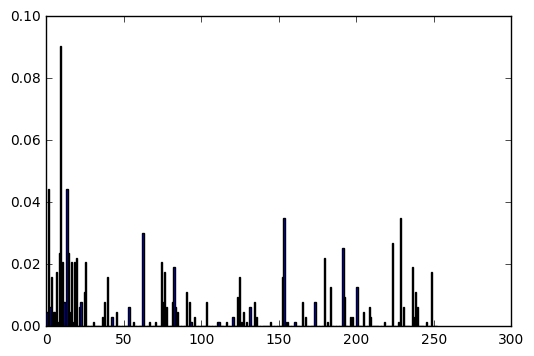

In [28]:
from xgboost import XGBClassifier
from matplotlib import pyplot
# load data
print(X_train.columns)
X_train_bis = X_train.drop("bidder_id",axis=1).values
y_train_bis = y_train.astype(int).values
model = XGBClassifier()
model.fit(X_train_bis,y_train_bis)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()